# Dimentionality reduction


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from bioservices import COG 

In [3]:
y = 'data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv'
training_file = 'data/all_gene_annotations.added_incompleteness_and_contamination.training.tsv'
testing_file = 'data/all_gene_annotations.added_incompleteness_and_contamination.testing.tsv'

#parametres
target_column = 'oxytolerance'
threads = 64

## Data

In [4]:
# Read GTDB
gtdb = pl.concat([
    pl.read_csv('data/bac120_metadata_r202.tsv', separator="\t"),
    pl.read_csv('data/ar122_metadata_r202.tsv', separator="\t")
])
gtdb = gtdb.filter(pl.col("gtdb_representative") == "t")
print("Read in {} GTDB reps".format(len(gtdb)))

gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(0).alias("domain"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(1).alias("phylum"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(2).alias("class"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(3).alias("order"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(4).alias("family"))
gtdb = gtdb.with_columns(pl.col("gtdb_taxonomy").str.split(';').list.get(5).alias("genus"))

Read in 47894 GTDB reps


In [5]:
gtdb

accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,gc_count,gc_percentage,genome_size,gtdb_genome_representative,gtdb_representative,gtdb_taxonomy,gtdb_type_designation,gtdb_type_designation_sources,gtdb_type_species_of_genus,l50_contigs,l50_scaffolds,longest_contig,longest_scaffold,lsu_23s_contig_len,lsu_23s_count,lsu_23s_length,lsu_23s_query_id,lsu_5s_contig_len,lsu_5s_count,lsu_5s_length,lsu_5s_query_id,lsu_silva_23s_blast_align_len,lsu_silva_23s_blast_bitscore,lsu_silva_23s_blast_evalue,lsu_silva_23s_blast_perc_identity,lsu_silva_23s_blast_subject_id,…,ncbi_taxonomy_unfiltered,ncbi_total_gap_length,ncbi_total_length,ncbi_translation_table,ncbi_trna_count,ncbi_type_material_designation,ncbi_ungapped_length,ncbi_unspanned_gaps,ncbi_wgs_master,protein_count,scaffold_count,ssu_contig_len,ssu_count,ssu_gg_blast_align_len,ssu_gg_blast_bitscore,ssu_gg_blast_evalue,ssu_gg_blast_perc_identity,ssu_gg_blast_subject_id,ssu_gg_taxonomy,ssu_length,ssu_query_id,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count,domain,phylum,class,order,family,genus
str,i64,f64,f64,i64,str,i64,f64,i64,f64,i64,i64,f64,i64,str,str,str,str,str,str,i64,i64,i64,i64,str,i64,str,str,str,i64,str,str,str,str,str,str,str,…,str,i64,i64,str,str,str,i64,i64,str,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str
"""GB_GCA_000024525.1""",0,100.0,0.89,454,"""o__Cytophagales (UID2936)""",336,25.0,7481814,88.111962,9,4258276,50.148941,8491258,"""GB_GCA_000024525.1""","""t""","""d__Bacteria;p__Bacteroidota;c_…","""type strain of species""","""LPSN; DSMZ""","""t""",1,1,8078757,8078757,"""8078757""",4,"""2807""","""CP001769.1""","""none""",0,"""none""","""none""","""2807""","""5184""","""0""","""100""","""CP001769.6728674.6731505""",…,"""d__Bacteria;x__FCB group;x__Ba…",0,8491258,"""11""","""49""","""assembly from type material""",8491258,0,"""none""",7129,9,"""8078757""",4,"""none""","""none""","""none""","""none""","""none""","""none""","""1503""","""CP001769.1""","""1495""","""2761""","""0""","""100""","""CP001769.6726840.6728334""","""Bacteria;Bacteroidota;Bacteroi…",0,20,47,0,"""d__Bacteria""","""p__Bacteroidota""","""c__Bacteroidia""","""o__Cytophagales""","""f__Spirosomaceae""","""g__Spirosoma"""
"""GB_GCA_000285855.2""",7,99.37,2.24,278,"""o__Clostridiales (UID1226)""",158,0.0,3538921,68.355703,526,1633519,39.182768,5177214,"""GB_GCA_000285855.2""","""t""","""d__Bacteria;p__Firmicutes_A;c_…","""not type material""","""none""","""f""",18,1,215746,3529697,"""5075""",1,"""2826""","""HE978695.1""","""none""",0,"""none""","""none""","""2826""","""5219""","""0""","""100""","""CAHL01000240.52.2884""",…,"""d__Bacteria;x__Terrabacteria g…",1008234,5177214,"""none""","""none""","""none""",4168980,0,"""CAHL00000000.1""",4285,53,"""5075""",1,"""none""","""none""","""none""","""none""","""none""","""none""","""1419""","""HE978695.1""","""1419""","""2569""","""0""","""99.366""","""AB559636.1.1522""","""Bacteria;Firmicutes;Clostridia…",1008234,18,54,0,"""d__Bacteria""","""p__Firmicutes_A""","""c__Clostridia""","""o__Lachnospirales""","""f__Lachnospiraceae""","""g__Blautia_A"""
"""GB_GCA_000307935.1""",0,68.88,0.0,451,"""c__Gammaproteobacteria (UID444…",270,0.0,1340520,95.97079,13,505174,36.166523,1396800,"""GB_GCA_000307935.1""","""t""","""d__Bacteria;p__Proteobacteria;…","""not type material""","""none""","""f""",2,2,402564,402564,"""53766""",1,"""2885""","""AMWX01000006.1""","""53766""",1,"""109""","""AMWX01000006.1""","""2885""","""5328""","""0""","""100""","""AMWX01000006.6511.9405""",…,"""d__Bacteria;p__Proteobacteria;…",0,1396800,"""11""","""33""","""none""",1396800,0,"""AMWX00000000.1""",1401,13,"""5376

In [6]:
# Read train and test
d_train = pl.read_csv(training_file,separator="\t")#accession fpr fnr {COGs}
print("Read train data: %s", d_train.shape)

d_test = pl.read_csv(testing_file,separator="\t")#accession fpr fnr {COGs}
print("Read test data: %s", d_test.shape)

# Add metadata (join based on accession)
d2_train = d_train.join(gtdb.select(['accession','domain', 'phylum','class','order','family','genus']), on="accession", how="left")#accession fpr fnr {COGs} phylum class order family
print("Total in d2 train data: %s", d2_train.shape)
d2_test = d_test.join(gtdb.select(['accession','domain', 'phylum','class','order','family','genus']), on="accession", how="left")#accession fpr fnr {COGs} phylum class order family
print("Total in d2 train data: %s", d2_test.shape)

Read train data: %s (114192, 2680)
Read test data: %s (33552, 2680)
Total in d2 train data: %s (114192, 2686)
Total in d2 train data: %s (33552, 2686)


In [7]:
d_test

accession,false_negative_rate,false_positive_rate,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,COG0015,COG0016,COG0017,COG0018,COG0019,COG0022,COG0023,COG0025,COG0026,COG0027,COG0028,COG0029,COG0030,COG0033,COG0035,COG0036,COG0038,COG0039,COG0041,COG0042,COG0043,COG0044,COG0045,COG0046,…,COG5496,COG5498,COG5499,COG5501,COG5517,COG5520,COG5524,COG5525,COG5531,COG5542,COG5553,COG5554,COG5555,COG5557,COG5565,COG5569,COG5570,COG5571,COG5573,COG5581,COG5590,COG5592,COG5597,COG5598,COG5605,COG5606,COG5610,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663
str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""GB_GCA_000383895.1""",0.0,0.0,2,1,0,1,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,2,1,1,1,1,1,3,0,1,1,1,1,1,0,…,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,2,0
"""GB_GCA_000383895.1""",0.0,0.1,2,1,0,2,0,0,0,0,1,1,1,1,0,2,1,0,1,0,1,1,2,2,1,1,1,4,3,0,2,1,1,1,1,1,…,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,2,0
"""GB_GCA_000383895.1""",0.0,0.2,2,2,0,4,0,1,0,0,1,3,1,2,0,2,1,0,1,0,2,1,3,1,1,1,1,2,4,0,1,1,1,1,1,1,…,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,2,0,1,0,1,0,2,0,0,0,1,0,0,0,0,0,2,0
"""GB_GCA_000383895.1""",0.0,0.3,2,2,0,3,0,0,1,0,2,1,2,1,0,3,3,1,1,0,2,1,3,1,2,1,3,2,3,0,2,3,1,2,1,0,…,0,0,0,0,1,0,0,0,2,0,0,0,0,1,0,0,1,0,0,3,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,2,1
"""GB_GCA_000383895.1""",0.0,0.4,4,2,1,1,0,0,2,2,1,1,3,1,1,2,2,0,2,0,2,1,2,1,4,1,2,3,4,0,2,2,2,2,2,1,…,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,3,0,1,0,3,0,0,0,2,0,0,0,0,0,2,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RS_GCF_903994035.1""",0.5,0.1,0,0,0,0,0,1,0,0,2,0,1,2,1,2,0,0,0,0,0,0,0,0,2,0,0,2,0,0,1,0,0,2,0,1,…,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
"""RS_GCF_903994035.1""",0.5,0.2,4,0,1,0,0,2,1,0,4,0,0,2,0,1,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,1,2,1,2,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
"""RS_GCF_903994035.1""",0.5,0.3,3,1,0,0,0,0,2,1,0,5,3,1,3,1,1,0,1,1,1,0,4,0,3,0,1,1,0,1,1,0,0,1,3,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# Read y
y0 = pl.read_csv(y, separator="\t")
y1 = y0.unique() # There are some duplicates in the cyanos, so dedup
print("Read y: %s", y1.shape)
print("Counts of each class amongst unique accessions: %s", y1.group_by(target_column).agg(pl.len()))#FIXED

Read y: %s (3161, 2)
Counts of each class amongst unique accessions: %s shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ str          ┆ u32  │
╞══════════════╪══════╡
│ anaerobe     ┆ 1055 │
│ aerobe       ┆ 2106 │
└──────────────┴──────┘


In [9]:
y0

accession,oxytolerance
str,str
"""RS_GCF_001040945.1""","""aerobe"""
"""RS_GCF_007995015.1""","""aerobe"""
"""RS_GCF_900100655.1""","""aerobe"""
"""RS_GCF_000243235.1""","""aerobe"""
"""RS_GCF_003387535.1""","""aerobe"""
…,…
"""RS_GCF_001870225.1""","""aerobe"""
"""RS_GCF_001870905.1""","""aerobe"""
"""RS_GCF_001890765.1""","""aerobe"""


In [10]:
d3_train = d2_train.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
print("Counts of each class in test data: %s", d3_train.group_by(target_column).agg(pl.len()))

d3_test = d2_test.join(y1, on="accession", how="inner") # Inner join because test accessions are in y1 but not in d2
print("Counts of each class in training data: %s", d3_test.group_by(target_column).agg(pl.len()))


Counts of each class in test data: %s shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ anaerobe     ┆ 29808 │
│ aerobe       ┆ 58356 │
└──────────────┴───────┘
Counts of each class in training data: %s shape: (2, 2)
┌──────────────┬───────┐
│ oxytolerance ┆ len   │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ anaerobe     ┆ 8172  │
│ aerobe       ┆ 17460 │
└──────────────┴───────┘


In [11]:
d3_test

accession,false_negative_rate,false_positive_rate,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,COG0015,COG0016,COG0017,COG0018,COG0019,COG0022,COG0023,COG0025,COG0026,COG0027,COG0028,COG0029,COG0030,COG0033,COG0035,COG0036,COG0038,COG0039,COG0041,COG0042,COG0043,COG0044,COG0045,COG0046,…,COG5525,COG5531,COG5542,COG5553,COG5554,COG5555,COG5557,COG5565,COG5569,COG5570,COG5571,COG5573,COG5581,COG5590,COG5592,COG5597,COG5598,COG5605,COG5606,COG5610,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663,domain,phylum,class,order,family,genus,oxytolerance
str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str
"""GB_GCA_000383895.1""",0.0,0.0,2,1,0,1,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,2,1,1,1,1,1,3,0,1,1,1,1,1,0,…,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,2,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Duganella""","""aerobe"""
"""GB_GCA_000383895.1""",0.0,0.1,2,1,0,2,0,0,0,0,1,1,1,1,0,2,1,0,1,0,1,1,2,2,1,1,1,4,3,0,2,1,1,1,1,1,…,0,1,0,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,2,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Duganella""","""aerobe"""
"""GB_GCA_000383895.1""",0.0,0.2,2,2,0,4,0,1,0,0,1,3,1,2,0,2,1,0,1,0,2,1,3,1,1,1,1,2,4,0,1,1,1,1,1,1,…,1,1,0,0,0,0,0,0,0,0,1,0,2,0,1,0,1,0,2,0,0,0,1,0,0,0,0,0,2,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Duganella""","""aerobe"""
"""GB_GCA_000383895.1""",0.0,0.3,2,2,0,3,0,0,1,0,2,1,2,1,0,3,3,1,1,0,2,1,3,1,2,1,3,2,3,0,2,3,1,2,1,0,…,0,2,0,0,0,0,1,0,0,1,0,0,3,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,2,1,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Duganella""","""aerobe"""
"""GB_GCA_000383895.1""",0.0,0.4,4,2,1,1,0,0,2,2,1,1,3,1,1,2,2,0,2,0,2,1,2,1,4,1,2,3,4,0,2,2,2,2,2,1,…,0,1,0,0,0,0,0,0,0,0,0,0,2,0,3,0,1,0,3,0,0,0,2,0,0,0,0,0,2,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Duganella""","""aerobe"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""RS_GCF_902859695.1""",0.5,0.1,1,1,0,1,0,0,0,0,0,1,3,0,0,1,1,1,1,0,0,0,5,0,1,0,1,0,2,0,2,1,0,1,2,0,…,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Achromobacter""","""aerobe"""
"""RS_GCF_902859695.1""",0.5,0.2,1,1,0,0,0,0,0,1,2,2,3,2,0,1,2,1,1,0,1,0,1,1,1,1,0,2,2,0,0,0,1,1,0,0,…,1,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Achromobacter""","""aerobe"""
"""RS_GCF_902859695.1""",0.5,0.3,2,2,1,2,0,0,1,0,3,1,2,1,0,3,0,0,1,2,2,1,6,0,2,0,1,1,1,1,3,2,0,2,0,0,…,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,"""d__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Burkholderiales""","""f__Burkholderiaceae""","""g__Achromobacter""","""aerobe"""


In [12]:
d3_bf_train = d3_train
d3_bf_test = d3_test

without noise (w/o FP & FN)

In [13]:
#w/o FP FN
print(f'Train before filtering {len(d3_train)}')
d3_train = d3_train.filter(pl.col("false_negative_rate") == 0)
d3_train = d3_train.filter(pl.col("false_positive_rate") == 0)
print(f'Train after filtering {len(d3_train)}')


#w/o FP FN
print(f'Test before filtering {len(d3_test)}')
d3_test = d3_test.filter(pl.col("false_negative_rate") == 0)
d3_test = d3_test.filter(pl.col("false_positive_rate") == 0)
print(f'Test after filtering {len(d3_test)}')

d3_train.head()

Train before filtering 88164
Train after filtering 2449
Test before filtering 25632
Test after filtering 712


accession,false_negative_rate,false_positive_rate,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,COG0015,COG0016,COG0017,COG0018,COG0019,COG0022,COG0023,COG0025,COG0026,COG0027,COG0028,COG0029,COG0030,COG0033,COG0035,COG0036,COG0038,COG0039,COG0041,COG0042,COG0043,COG0044,COG0045,COG0046,…,COG5525,COG5531,COG5542,COG5553,COG5554,COG5555,COG5557,COG5565,COG5569,COG5570,COG5571,COG5573,COG5581,COG5590,COG5592,COG5597,COG5598,COG5605,COG5606,COG5610,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663,domain,phylum,class,order,family,genus,oxytolerance
str,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str
"""GB_GCA_000010565.1""",0.0,0.0,1,1,0,1,2,1,1,1,1,2,1,1,1,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,1,0,…,0,0,1,0,0,0,1,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Pelotomaculaceae""","""g__Pelotomaculum""","""anaerobe"""
"""GB_GCA_000018565.1""",0.0,0.0,1,1,1,3,3,0,1,1,1,2,1,1,1,2,2,0,0,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,…,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,"""d__Bacteria""","""p__Chloroflexota""","""c__Chloroflexia""","""o__Chloroflexales""","""f__Herpetosiphonaceae""","""g__Herpetosiphon""","""aerobe"""
"""GB_GCA_000145985.1""",0.0,0.0,1,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Archaea""","""p__Thermoproteota""","""c__Thermoproteia""","""o__Sulfolobales""","""f__Ignisphaeraceae""","""g__Ignisphaera""","""anaerobe"""
"""GB_GCA_000210715.1""",0.0,0.0,0,0,0,0,0,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1,0,1,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""d__Bacteria""","""p__Synergistota""","""c__Synergistia""","""o__Synergistales""","""f__Aminobacteriaceae""","""g__Fretibacterium""","""anaerobe"""
"""GB_GCA_000214705.1""",0.0,0.0,1,1,0,1,2,1,1,2,1,1,1,1,0,1,1,0,0,0,0,0,2,1,1,0,0,1,0,1,1,1,1,1,2,0,…,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"""d__Bacteria""","""p__Firmicutes_B""","""c__Desulfotomaculia""","""o__Desulfotomaculales""","""f__Desulfovirgulaceae""","""g__Desulfofundulus""","""anaerobe"""


In [14]:
y = y1

classes_map = {
    'anaerobe': 0,
    'aerobe': 1,
}      

#train

y_train = d3_train.with_columns(
    pl.col(target_column)
    .replace_strict(classes_map, default='unknown')
    .alias(target_column)
)

y_train = y_train.with_columns(
    pl.col(target_column).cast(pl.Int32)  # Change to Int32
)
            
print("Counts of y in Train: %s", y_train.group_by(target_column).agg(pl.len()))

y_train = y_train.to_pandas()
y_train = y_train.iloc[:, -1]

#test

y_test = d3_test.with_columns(
    pl.col(target_column)
    .replace_strict(classes_map, default='unknown')
    .alias(target_column)
)

y_test = y_test.with_columns(
    pl.col(target_column).cast(pl.Int32)  # Change to Int32
)
            
print("Counts of y in Test: %s", y_test.group_by(target_column).agg(pl.len()))

y_test = y_test.to_pandas()
y_test = y_test.iloc[:, -1]

Counts of y in Train: %s shape: (2, 2)
┌──────────────┬──────┐
│ oxytolerance ┆ len  │
│ ---          ┆ ---  │
│ i32          ┆ u32  │
╞══════════════╪══════╡
│ 0            ┆ 828  │
│ 1            ┆ 1621 │
└──────────────┴──────┘
Counts of y in Test: %s shape: (2, 2)
┌──────────────┬─────┐
│ oxytolerance ┆ len │
│ ---          ┆ --- │
│ i32          ┆ u32 │
╞══════════════╪═════╡
│ 0            ┆ 227 │
│ 1            ┆ 485 │
└──────────────┴─────┘


In [15]:
y_test.head()

0    1
1    1
2    1
3    1
4    1
Name: oxytolerance, dtype: int32

In [16]:
X_train = d3_train.select(pl.exclude(['accession',target_column,'domain','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X_train = X_train.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'], axis=1)


X_test = d3_test.select(pl.exclude(['accession',target_column,'domain','phylum','class','order','family','genus','false_negative_rate','false_positive_rate'])).to_pandas()

# Blacklist these as they aren't in the current ancestral file, not sure why
X_test = X_test.drop(['COG0411', 'COG0459', 'COG0564', 'COG1344', 'COG4177'], axis=1)

X_train

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,...,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663
0,1,1,0,1,2,1,1,1,1,2,...,0,0,0,0,2,0,0,0,0,1
1,1,1,1,3,3,0,1,1,1,2,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,2,1,1,2,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2445,1,1,1,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2446,1,1,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2447,2,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Models: XGBOOST

In [17]:
#model
pipe = make_pipeline(
    MaxAbsScaler(),
    XGBClassifier(n_jobs=threads, use_label_encoder=False)
)

In [18]:
#baseline
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred)
baseline_accuracy

0.9662921348314607

### Variance

In [19]:
X_train#all calculations made on train

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,...,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663
0,1,1,0,1,2,1,1,1,1,2,...,0,0,0,0,2,0,0,0,0,1
1,1,1,1,3,3,0,1,1,1,2,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,2,1,1,2,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2445,1,1,1,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2446,1,1,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2447,2,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
scaler = MaxAbsScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

variances = X_train_scaled.var()
variances

variances_series = pd.Series(variances)
variances_series

COG0001    0.014767
COG0002    0.005788
COG0003    0.021459
COG0004    0.014169
COG0005    0.035578
             ...   
COG5640    0.003503
COG5643    0.003360
COG5650    0.004887
COG5652    0.042194
COG5663    0.025973
Length: 2672, dtype: float64

In [21]:
variances_series_sorted = variances_series.sort_values(ascending=False)
variances_series_sorted

COG3124    0.177773
COG3242    0.140529
COG4137    0.137808
COG2969    0.131986
COG3073    0.121664
             ...   
COG3225    0.000408
COG5078    0.000408
COG1449    0.000000
COG1100    0.000000
COG1112    0.000000
Length: 2672, dtype: float64

In [22]:
for cog in variances_series_sorted.index:
    print(cog)

COG3124
COG3242
COG4137
COG2969
COG3073
COG3651
COG5481
COG5375
COG5387
COG2813
COG5468
COG3763
COG5605
COG5385
COG5452
COG4582
COG3725
COG4825
COG0543
COG3529
COG3782
COG5317
COG1587
COG1965
COG0850
COG4208
COG0555
COG1281
COG2824
COG1577
COG1259
COG1678
COG1546
COG4531
COG1286
COG1803
COG5405
COG0382
COG1407
COG2009
COG3363
COG3705
COG0140
COG1847
COG1663
COG1671
COG0390
COG3022
COG1666
COG1828
COG4116
COG2891
COG0047
COG2094
COG1489
COG1534
COG0430
COG0007
COG0780
COG0575
COG1903
COG1420
COG2257
COG2073
COG1579
COG1419
COG1891
COG4955
COG3030
COG3663
COG0156
COG2967
COG1952
COG2981
COG1610
COG0851
COG2054
COG0297
COG0293
COG0077
COG2839
COG1564
COG1897
COG1188
COG0565
COG1565
COG2039
COG1605
COG1358
COG1949
COG1515
COG3688
COG0838
COG0694
COG2089
COG1845
COG1490
COG2838
COG0617
COG1388
COG1072
COG1550
COG1243
COG2316
COG2973
COG0283
COG2927
COG2065
COG2965
COG0271
COG1939
COG0377
COG2509
COG0218
COG2938
COG2921
COG1169
COG1854
COG3762
COG0027
COG2983
COG3334
COG0579
COG4133
COG0743


#### Saving COGs with highest variance 
<=> **Removing** COGs one-by-one from **the lowest** variance to the highest one

In [23]:
def train_model_highest_var(variances_series_sorted):
    df_metrics_var_highest = pd.DataFrame(columns=['N_features', 'min_var', 'accuracy_test', 'accuracy_train', 'mean_cv'])
    
    # all features
    all_features = variances_series_sorted.index
    curr_features = all_features#variances_series_sorted.index
    pipe.fit(X_train[curr_features], y_train)
    
    y_pred = pipe.predict(X_test[curr_features])
    accuracy_test = accuracy_score(y_test, y_pred)
    
    accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
    cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
    mean_cv_accuracy = np.mean(cv_scores)
    #print(f'CV {mean_cv_accuracy}')
    df_metrics_var_highest.loc[len(df_metrics_var_highest)] = [int(len(curr_features)), variances_series_sorted[curr_features[-1]], accuracy_test, accuracy_train, mean_cv_accuracy]
    #print(df_metrics_var_highest)
    
    for _ in tqdm(range(len(all_features))):
        
        # Remove COG with the lowest variance
        curr_features = curr_features[:-1]
    
        if len(curr_features) < 10:
            break
    
        pipe.fit(X_train[curr_features], y_train)
    
        y_pred = pipe.predict(X_test[curr_features])
        accuracy_test = accuracy_score(y_test, y_pred)
        
        accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
        cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
        mean_cv_accuracy = np.mean(cv_scores)
        #print(f'CV {mean_cv_accuracy}')
        
        df_metrics_var_highest.loc[len(df_metrics_var_highest)] = [int(len(curr_features)), variances_series_sorted[curr_features[-1]], accuracy_test, accuracy_train, mean_cv_accuracy]
        #print(df_metrics_var_highest)
    
    
    return df_metrics_var_highest

In [24]:
#save or read the data
var_highest_result_name = './results/df_metrics_var_highest.csv'

if not os.path.exists(var_highest_result_name):
    df_metrics_var_highest = train_model_highest_var(variances_series_sorted)
    df_metrics_var_highest.to_csv(var_highest_result_name, index=False)

else:
    df_metrics_var_highest = pd.read_csv(var_highest_result_name)

df_metrics_var_highest

100%|████████████████████████████████▉| 2662/2672 [1:13:13<00:16,  1.65s/it]


,N_features,min_var,accuracy_test,accuracy_train,mean_cv
0,2672.0,0.000000,0.970506,1.000000,0.973050
1,2671.0,0.000000,0.970506,1.000000,0.973050
2,2670.0,0.000000,0.970506,1.000000,0.973050
3,2669.0,0.000408,0.970506,1.000000,0.973050
4,2668.0,0.000408,0.970506,1.000000,0.973050
...,...,...,...,...,...
2658,14.0,0.087115,0.842697,0.873418,0.862798
2659,13.0,0.087774,0.842697,0.873418,0.862798
2660,12.0,0.091048,0.865169,0.871376,0.861573
2661,11.0,0.091699,0.830056,0.871376,0.861573


In [24]:
#save or read the data
var_highest_result_name = './results/df_metrics_var_highest.csv'

if not os.path.exists(var_highest_result_name):
    df_metrics_var_highest = train_model_highest_var(variances_series_sorted)
    df_metrics_var_highest.to_csv(var_highest_result_name, index=False)

else:
    df_metrics_var_highest = pd.read_csv(var_highest_result_name)

df_metrics_var_highest

,N_features,min_var,accuracy_test,accuracy_train,mean_cv
0,2672.0,0.000000,0.970506,1.000000,0.973050
1,2671.0,0.000000,0.970506,1.000000,0.973050
2,2670.0,0.000000,0.970506,1.000000,0.973050
3,2669.0,0.000408,0.970506,1.000000,0.973050
4,2668.0,0.000408,0.970506,1.000000,0.973050
...,...,...,...,...,...
2658,14.0,0.087115,0.842697,0.873418,0.862798
2659,13.0,0.087774,0.842697,0.873418,0.862798
2660,12.0,0.091048,0.865169,0.871376,0.861573
2661,11.0,0.091699,0.830056,0.871376,0.861573


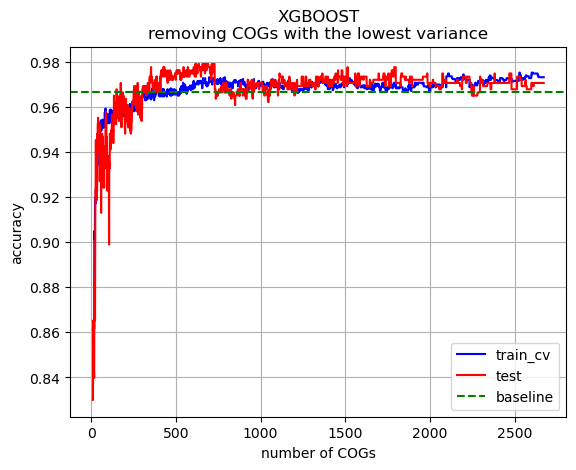

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the lowest variance')

ax.plot(df_metrics_var_highest['N_features'], df_metrics_var_highest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_var_highest['N_features'], df_metrics_var_highest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

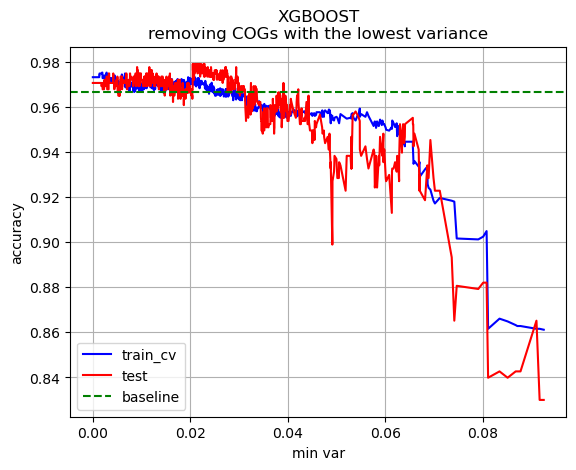

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel("min var")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the lowest variance')

ax.plot(df_metrics_var_highest['min_var'], df_metrics_var_highest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_var_highest['min_var'], df_metrics_var_highest['accuracy_test'], 'r-', label='test')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

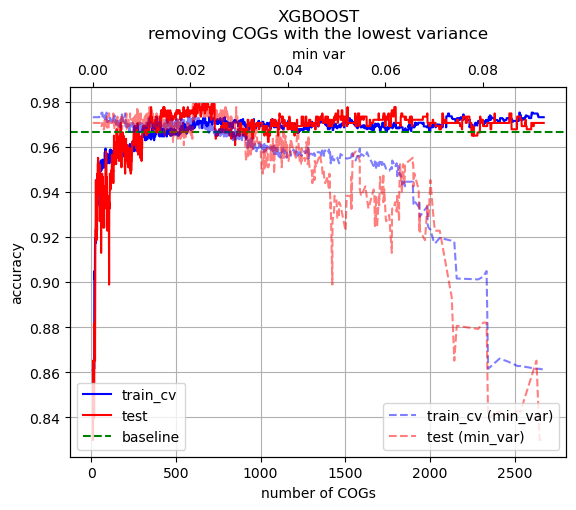

In [27]:
fig, ax = plt.subplots()

ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the lowest variance')

ax.plot(df_metrics_var_highest['N_features'], df_metrics_var_highest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_var_highest['N_features'], df_metrics_var_highest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

# ax.set_ylim(0.9, 1.0)

ax2 = ax.twiny()  

ax2.plot(df_metrics_var_highest['min_var'], df_metrics_var_highest['mean_cv'], 'b--', label='train_cv (min_var)', alpha=0.5)
ax2.plot(df_metrics_var_highest['min_var'], df_metrics_var_highest['accuracy_test'], 'r--', label='test (min_var)', alpha=0.5)

ax2.set_xlabel("min var")

ax.legend(loc='lower left')
ax2.legend(loc='lower right')

ax.grid()

plt.show()

#### Saving COGs with lowest variance 
<=> **Removing** COGs one-by-one from **the highest** variance to the lowest one

In [28]:
def train_model_lowest_var(variances_series_sorted):
    
    df_metrics_var_lowest = pd.DataFrame(columns=['N_features', 'max_var', 'accuracy_test', 'accuracy_train', 'mean_cv'])
    
    # all features
    all_features = variances_series_sorted.index
    curr_features = all_features#variances_series_sorted.index
    pipe.fit(X_train[curr_features], y_train)
    
    y_pred = pipe.predict(X_test[curr_features])
    accuracy_test = accuracy_score(y_test, y_pred)
    
    accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
    cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
    mean_cv_accuracy = np.mean(cv_scores)
    #print(f'CV {mean_cv_accuracy}')
    df_metrics_var_lowest.loc[len(df_metrics_var_lowest)] = [int(len(curr_features)), variances_series_sorted[curr_features[0]], accuracy_test, accuracy_train, mean_cv_accuracy]
    #print(df_metrics_var_lowest)
    
    for _ in tqdm(range(len(all_features))):
        
        # Remove COG with the lowest variance
        curr_features = curr_features[1:]
        #print(curr_features)
    
        if len(curr_features) < 10:
            break
    
        pipe.fit(X_train[curr_features], y_train)
    
        y_pred = pipe.predict(X_test[curr_features])
        accuracy_test = accuracy_score(y_test, y_pred)
        
        accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
        cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
        mean_cv_accuracy = np.mean(cv_scores)
        #print(f'CV {mean_cv_accuracy}')
        
        df_metrics_var_lowest.loc[len(df_metrics_var_lowest)] = [int(len(curr_features)), variances_series_sorted[curr_features[0]], accuracy_test, accuracy_train, mean_cv_accuracy]
        #print(df_metrics_var_lowest)
    
    return df_metrics_var_lowest

In [29]:
#save or read the data
var_lowest_result_name = './results/df_metrics_var_lowest.csv'

if not os.path.exists(var_lowest_result_name):
    df_metrics_var_lowest = train_model_lowest_var(variances_series_sorted)
    df_metrics_var_lowest.to_csv(var_lowest_result_name, index=False)

else:
    df_metrics_var_lowest = pd.read_csv(var_lowest_result_name)

df_metrics_var_lowest

100%|████████████████████████████████▉| 2662/2672 [1:22:34<00:18,  1.86s/it]


,N_features,max_var,accuracy_test,accuracy_train,mean_cv
0,2672.0,0.177773,0.970506,1.000000,0.973050
1,2671.0,0.140529,0.970506,1.000000,0.973050
2,2670.0,0.137808,0.970506,1.000000,0.973050
3,2669.0,0.131986,0.970506,1.000000,0.973050
4,2668.0,0.121664,0.970506,1.000000,0.973050
...,...,...,...,...,...
2658,14.0,0.000510,0.675562,0.663128,0.662721
2659,13.0,0.000408,0.681180,0.661903,0.661903
2660,12.0,0.000408,0.681180,0.661903,0.661903
2661,11.0,0.000408,0.681180,0.661903,0.661903


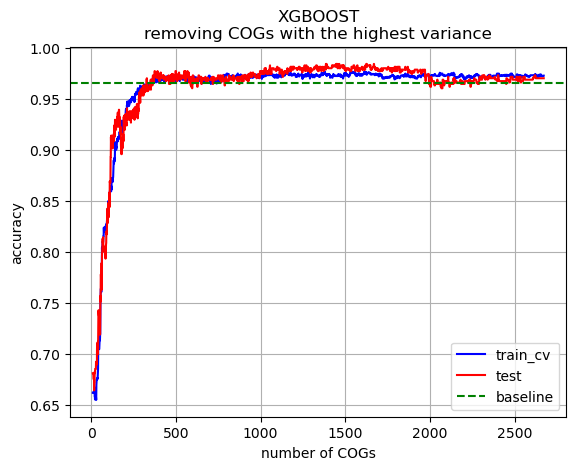

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest variance')

ax.plot(df_metrics_var_lowest['N_features'], df_metrics_var_lowest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_var_lowest['N_features'], df_metrics_var_lowest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

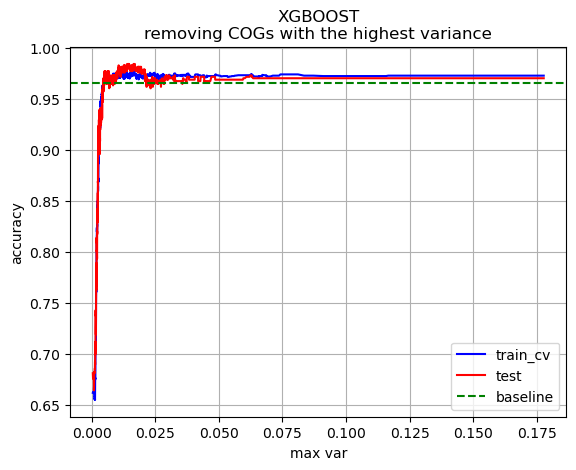

In [31]:
fig, ax = plt.subplots()
ax.set_xlabel("max var")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest variance')

ax.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['accuracy_test'], 'r-', label='test')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

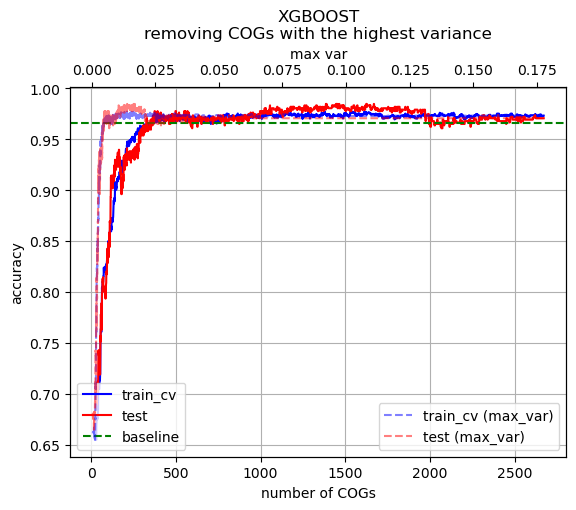

In [32]:
fig, ax = plt.subplots()

ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest variance')

ax.plot(df_metrics_var_lowest['N_features'], df_metrics_var_lowest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_var_lowest['N_features'], df_metrics_var_lowest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

# ax.set_ylim(0.9, 1.0)

ax2 = ax.twiny()  

ax2.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['mean_cv'], 'b--', label='train_cv (max_var)', alpha=0.5)
ax2.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['accuracy_test'], 'r--', label='test (max_var)', alpha=0.5)

ax2.set_xlabel("max var")

ax.legend(loc='lower left')
ax2.legend(loc='lower right')

ax.grid()

plt.show()

#### Some additional plots

**highest vs lowest var**

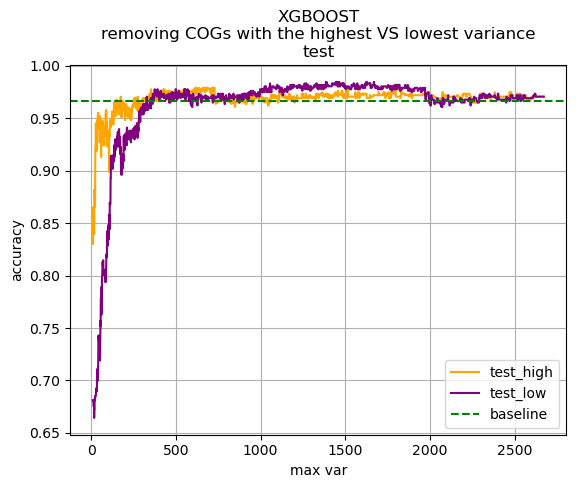

In [33]:
#Only test accuracy

fig, ax = plt.subplots()
ax.set_xlabel("max var")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest VS lowest variance\ntest')

ax.plot(df_metrics_var_highest['N_features'], df_metrics_var_highest['accuracy_test'], c='orange', label='test_high')
ax.plot(df_metrics_var_lowest['N_features'], df_metrics_var_lowest['accuracy_test'], c='purple', label='test_low')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

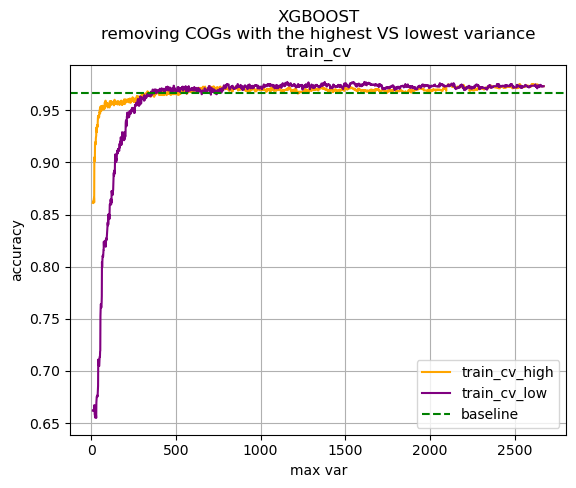

In [34]:
#Only train_cv accuracy

fig, ax = plt.subplots()
ax.set_xlabel("max var")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest VS lowest variance\ntrain_cv')

ax.plot(df_metrics_var_highest['N_features'], df_metrics_var_highest['mean_cv'], c='orange', label='train_cv_high')
ax.plot(df_metrics_var_lowest['N_features'], df_metrics_var_lowest['mean_cv'], c='purple', label='train_cv_low')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

**add accuracy for train without cross-validation**

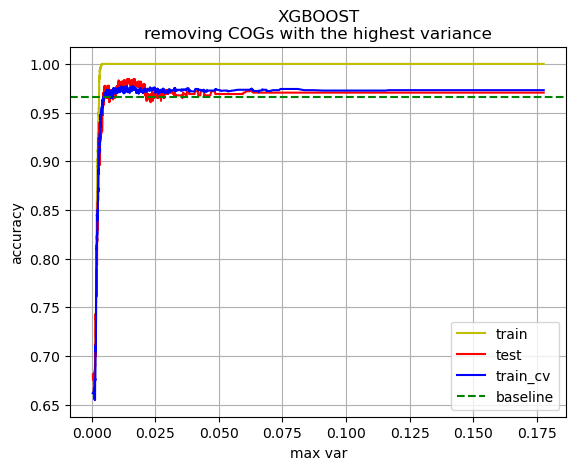

In [35]:
fig, ax = plt.subplots()
ax.set_xlabel("max var")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest variance')

ax.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['accuracy_train'], 'y-', label='train')
ax.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['accuracy_test'], 'r-', label='test')
ax.plot(df_metrics_var_lowest['max_var'], df_metrics_var_lowest['mean_cv'], 'b-', label='train_cv')


ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.1)
ax.legend()
ax.grid()

**with cross-validation**

### MI

In [19]:
X_train#all calculations made on train

,COG0001,COG0002,COG0003,COG0004,COG0005,COG0007,COG0008,COG0010,COG0012,COG0013,...,COG5611,COG5615,COG5621,COG5625,COG5632,COG5640,COG5643,COG5650,COG5652,COG5663
0,1,1,0,1,2,1,1,1,1,2,...,0,0,0,0,2,0,0,0,0,1
1,1,1,1,3,3,0,1,1,1,2,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,2,1,1,2,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
2445,1,1,1,2,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2446,1,1,0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2447,2,1,0,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
scaler = MaxAbsScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

mutual_info = mutual_info_classif(X_train_scaled, y_train)
mutual_info_series = pd.Series(mutual_info, index=X_train.columns)
mutual_info_series

COG0001    0.044482
COG0002    0.021793
COG0003    0.015924
COG0004    0.056666
COG0005    0.029399
             ...   
COG5640    0.000000
COG5643    0.013786
COG5650    0.014070
COG5652    0.000000
COG5663    0.000891
Length: 2672, dtype: float64

In [21]:
mutual_info_series_sorted = mutual_info_series.sort_values(ascending=False)
mutual_info_series_sorted

COG0109    0.378895
COG1592    0.347944
COG1612    0.339722
COG0026    0.331823
COG0567    0.287421
             ...   
COG0390    0.000000
COG3721    0.000000
COG3722    0.000000
COG3727    0.000000
COG3121    0.000000
Length: 2672, dtype: float64

In [22]:
for cog in mutual_info_series_sorted.index:
    print(cog)

COG0109
COG1592
COG1612
COG0026
COG0567
COG0508
COG0843
COG0276
COG1014
COG0065
COG1328
COG0365
COG1764
COG1054
COG0320
COG0167
COG4231
COG1838
COG0225
COG1951
COG0543
COG0369
COG0229
COG4624
COG0788
COG0783
COG1342
COG1252
COG3185
COG2768
COG0045
COG0114
COG1741
COG0405
COG1578
COG0074
COG0400
COG0221
COG2897
COG1313
COG0370
COG1149
COG0259
COG1249
COG0415
COG0408
COG1230
COG2224
COG0805
COG0404
COG2352
COG2848
COG0288
COG0321
COG0826
COG2225
COG4866
COG0509
COG1237
COG1012
COG1852
COG2377
COG1017
COG1146
COG2316
COG0659
COG0861
COG1845
COG0260
COG2191
COG3540
COG3483
COG1770
COG3324
COG2764
COG0354
COG3508
COG0208
COG2761
COG3635
COG1062
COG3844
COG1090
COG1678
COG0719
COG2967
COG4977
COG3830
COG1835
COG2072
COG2509
COG2350
COG1908
COG2166
COG0181
COG1156
COG0302
COG1505
COG2335
COG1946
COG1269
COG3211
COG0364
COG1394
COG2366
COG0271
COG0300
COG0431
COG2808
COG3346
COG1456
COG3695
COG1350
COG3217
COG2086
COG1775
COG1527
COG0648
COG2375
COG3894
COG2223
COG0753
COG1894
COG2303
COG3265


#### Saving COGs with highest MI 
<=> **Removing** COGs one-by-one from **the lowest** MI to the highest one

In [23]:
def train_model_highest_mi(mutual_info_series_sorted):
    df_metrics_mi_highest = pd.DataFrame(columns=['N_features', 'min_mi', 'accuracy_test', 'accuracy_train', 'mean_cv'])
    
    # all features
    all_features = mutual_info_series_sorted.index
    curr_features = all_features#mutual_info_series_sorted.index
    pipe.fit(X_train[curr_features], y_train)
    
    y_pred = pipe.predict(X_test[curr_features])
    accuracy_test = accuracy_score(y_test, y_pred)
    
    accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
    cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
    mean_cv_accuracy = np.mean(cv_scores)
    #print(f'CV {mean_cv_accuracy}')
    df_metrics_mi_highest.loc[len(df_metrics_mi_highest)] = [int(len(curr_features)), mutual_info_series_sorted[curr_features[-1]], accuracy_test, accuracy_train, mean_cv_accuracy]
    #print(df_metrics_mi_highest)
    
    for _ in tqdm(range(len(all_features))):
        
        # Remove COG with the lowest MI
        curr_features = curr_features[:-1]
    
        if len(curr_features) < 10:
            break
    
        pipe.fit(X_train[curr_features], y_train)
    
        y_pred = pipe.predict(X_test[curr_features])
        accuracy_test = accuracy_score(y_test, y_pred)
        
        accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
        cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
        mean_cv_accuracy = np.mean(cv_scores)
        #print(f'CV {mean_cv_accuracy}')
        
        df_metrics_mi_highest.loc[len(df_metrics_mi_highest)] = [int(len(curr_features)), mutual_info_series_sorted[curr_features[-1]], accuracy_test, accuracy_train, mean_cv_accuracy]
        #print(df_metrics_mi_highest)
    
    
    return df_metrics_mi_highest

In [24]:
#save or read the data
mi_highest_result_name = './results/df_metrics_mi_highest.csv'

if not os.path.exists(mi_highest_result_name):
    df_metrics_mi_highest = train_model_highest_mi(mutual_info_series_sorted)
    df_metrics_mi_highest.to_csv(mi_highest_result_name, index=False)

else:
    df_metrics_mi_highest = pd.read_csv(mi_highest_result_name)

df_metrics_mi_highest

100%|████████████████████████████████▉| 2662/2672 [1:18:47<00:17,  1.78s/it]


,N_features,min_mi,accuracy_test,accuracy_train,mean_cv
0,2672.0,0.000000,0.973315,1.000000,0.973866
1,2671.0,0.000000,0.973315,1.000000,0.973866
2,2670.0,0.000000,0.973315,1.000000,0.973866
3,2669.0,0.000000,0.973315,1.000000,0.973866
4,2668.0,0.000000,0.973315,1.000000,0.973050
...,...,...,...,...,...
2658,14.0,0.225033,0.976124,0.987342,0.962023
2659,13.0,0.228195,0.963483,0.986525,0.957121
2660,12.0,0.245586,0.962079,0.982850,0.955491
2661,11.0,0.249249,0.959270,0.979992,0.957122


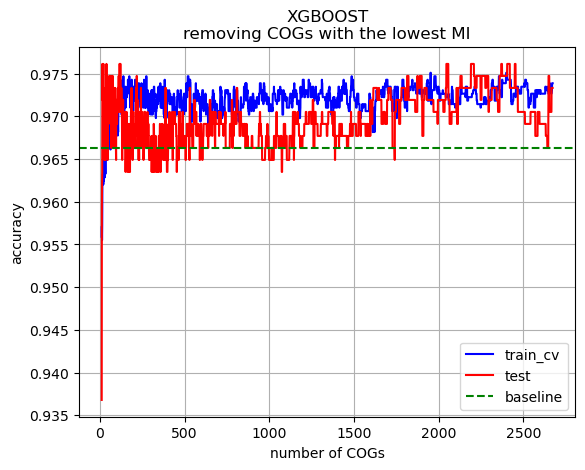

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the lowest MI')

ax.plot(df_metrics_mi_highest['N_features'], df_metrics_mi_highest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_mi_highest['N_features'], df_metrics_mi_highest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

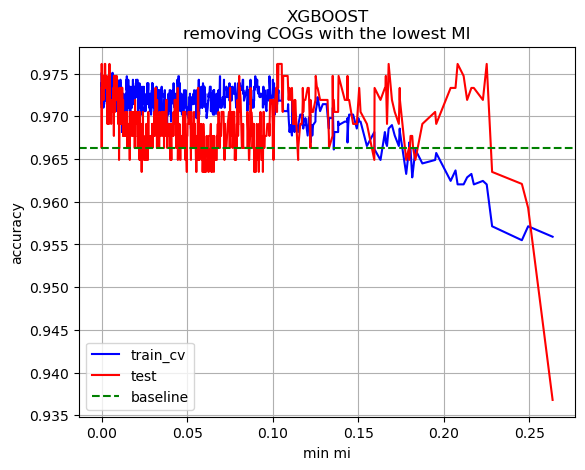

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel("min mi")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the lowest MI')

ax.plot(df_metrics_mi_highest['min_mi'], df_metrics_mi_highest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_mi_highest['min_mi'], df_metrics_mi_highest['accuracy_test'], 'r-', label='test')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

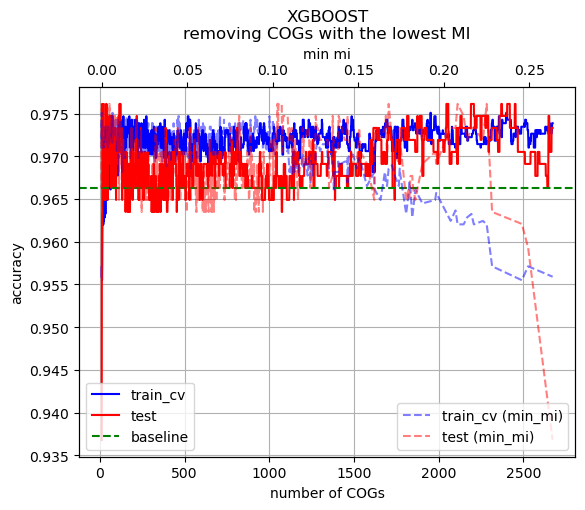

In [27]:
fig, ax = plt.subplots()

ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the lowest MI')

ax.plot(df_metrics_mi_highest['N_features'], df_metrics_mi_highest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_mi_highest['N_features'], df_metrics_mi_highest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

# ax.set_ylim(0.9, 1.0)

ax2 = ax.twiny()  

ax2.plot(df_metrics_mi_highest['min_mi'], df_metrics_mi_highest['mean_cv'], 'b--', label='train_cv (min_mi)', alpha=0.5)
ax2.plot(df_metrics_mi_highest['min_mi'], df_metrics_mi_highest['accuracy_test'], 'r--', label='test (min_mi)', alpha=0.5)

ax2.set_xlabel("min mi")

ax.legend(loc='lower left')
ax2.legend(loc='lower right')

ax.grid()

plt.show()

#### Saving COGs with lowest MI 
<=> **Removing** COGs one-by-one from **the highest** MI to the lowest one

In [28]:
def train_model_lowest_mi(mutual_info_series_sorted):
    
    df_metrics_mi_lowest = pd.DataFrame(columns=['N_features', 'max_mi', 'accuracy_test', 'accuracy_train', 'mean_cv'])
    
    # all features
    all_features = mutual_info_series_sorted.index
    curr_features = all_features#mutual_info_series_sorted.index
    pipe.fit(X_train[curr_features], y_train)
    
    y_pred = pipe.predict(X_test[curr_features])
    accuracy_test = accuracy_score(y_test, y_pred)
    
    accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
    cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
    mean_cv_accuracy = np.mean(cv_scores)
    #print(f'CV {mean_cv_accuracy}')
    df_metrics_mi_lowest.loc[len(df_metrics_mi_lowest)] = [int(len(curr_features)), mutual_info_series_sorted[curr_features[0]], accuracy_test, accuracy_train, mean_cv_accuracy]
    #print(df_metrics_mi_lowest)
    
    for _ in tqdm(range(len(all_features))):
        
        # Remove COG with the lowest MI
        curr_features = curr_features[1:]
        #print(curr_features)
    
        if len(curr_features) < 10:
            break
    
        pipe.fit(X_train[curr_features], y_train)
    
        y_pred = pipe.predict(X_test[curr_features])
        accuracy_test = accuracy_score(y_test, y_pred)
        
        accuracy_train = accuracy_score(y_train, pipe.predict(X_train[curr_features]))
    
        cv_scores = cross_val_score(pipe, X_train[curr_features], y_train, cv=5)
        mean_cv_accuracy = np.mean(cv_scores)
        #print(f'CV {mean_cv_accuracy}')
        
        df_metrics_mi_lowest.loc[len(df_metrics_mi_lowest)] = [int(len(curr_features)), mutual_info_series_sorted[curr_features[0]], accuracy_test, accuracy_train, mean_cv_accuracy]
        #print(df_metrics_mi_lowest)
    
    return df_metrics_mi_lowest

In [29]:
#save or read the data
mi_lowest_result_name = './results/df_metrics_mi_lowest.csv'

if not os.path.exists(mi_lowest_result_name):
    df_metrics_mi_lowest = train_model_lowest_mi(mutual_info_series_sorted)
    df_metrics_mi_lowest.to_csv(mi_lowest_result_name, index=False)

else:
    df_metrics_mi_lowest = pd.read_csv(mi_lowest_result_name)

df_metrics_mi_lowest

100%|████████████████████████████████▉| 2662/2672 [1:23:05<00:18,  1.87s/it]


,N_features,max_mi,accuracy_test,accuracy_train,mean_cv
0,2672.0,0.378895,0.973315,1.000000,0.973866
1,2671.0,0.347944,0.976124,1.000000,0.973459
2,2670.0,0.339722,0.978933,1.000000,0.974275
3,2669.0,0.331823,0.971910,1.000000,0.971416
4,2668.0,0.287421,0.970506,1.000000,0.973049
...,...,...,...,...,...
2658,14.0,0.000000,0.761236,0.808085,0.757459
2659,13.0,0.000000,0.748596,0.795018,0.735413
2660,12.0,0.000000,0.745787,0.792568,0.744802
2661,11.0,0.000000,0.728933,0.770927,0.730915


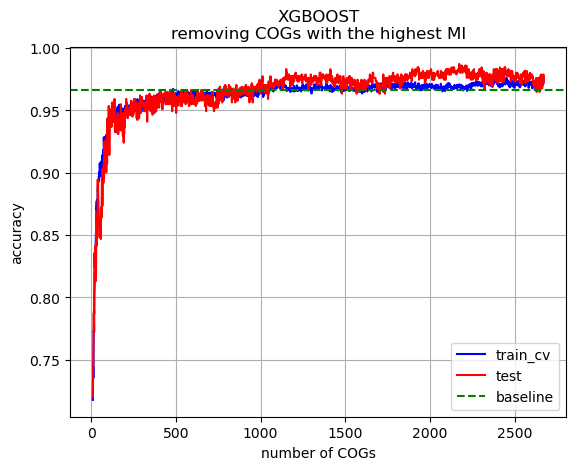

In [30]:
fig, ax = plt.subplots()
ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest MI')

ax.plot(df_metrics_mi_lowest['N_features'], df_metrics_mi_lowest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_mi_lowest['N_features'], df_metrics_mi_lowest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

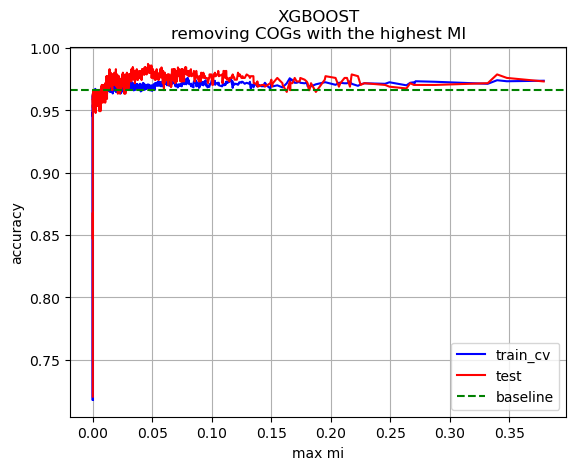

In [31]:
fig, ax = plt.subplots()
ax.set_xlabel("max mi")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest MI')

ax.plot(df_metrics_mi_lowest['max_mi'], df_metrics_mi_lowest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_mi_lowest['max_mi'], df_metrics_mi_lowest['accuracy_test'], 'r-', label='test')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

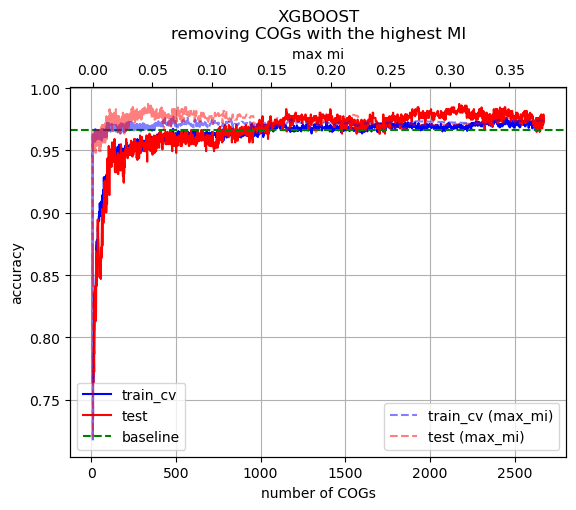

In [32]:
fig, ax = plt.subplots()

ax.set_xlabel("number of COGs")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest MI')

ax.plot(df_metrics_mi_lowest['N_features'], df_metrics_mi_lowest['mean_cv'], 'b-', label='train_cv')
ax.plot(df_metrics_mi_lowest['N_features'], df_metrics_mi_lowest['accuracy_test'], 'r-', label='test')
ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

# ax.set_ylim(0.9, 1.0)

ax2 = ax.twiny()  

ax2.plot(df_metrics_mi_lowest['max_mi'], df_metrics_mi_lowest['mean_cv'], 'b--', label='train_cv (max_mi)', alpha=0.5)
ax2.plot(df_metrics_mi_lowest['max_mi'], df_metrics_mi_lowest['accuracy_test'], 'r--', label='test (max_mi)', alpha=0.5)

ax2.set_xlabel("max mi")

ax.legend(loc='lower left')
ax2.legend(loc='lower right')

ax.grid()

plt.show()

#### Some additional plots

**highest vs lowest mi**

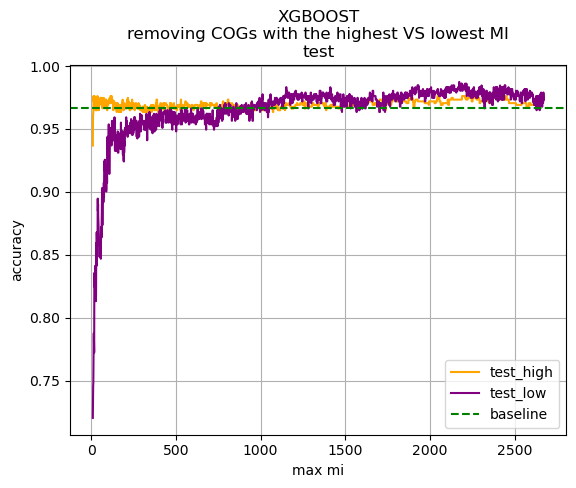

In [33]:
#Only test accuracy

fig, ax = plt.subplots()
ax.set_xlabel("max mi")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest VS lowest MI\ntest')

ax.plot(df_metrics_mi_highest['N_features'], df_metrics_mi_highest['accuracy_test'], c='orange', label='test_high')
ax.plot(df_metrics_mi_lowest['N_features'], df_metrics_mi_lowest['accuracy_test'], c='purple', label='test_low')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()

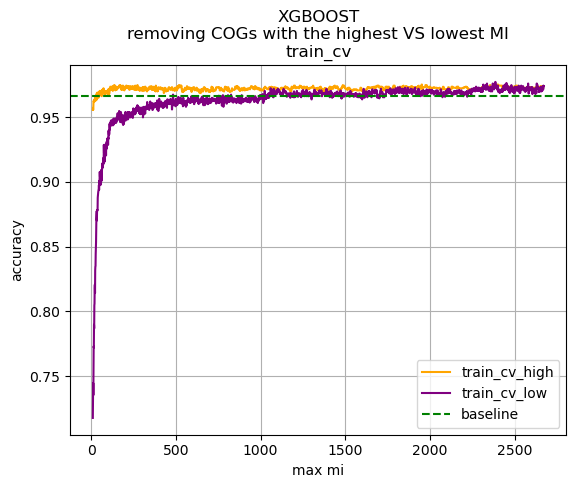

In [34]:
#Only train_cv accuracy

fig, ax = plt.subplots()
ax.set_xlabel("max mi")
ax.set_ylabel("accuracy")
plt.title('XGBOOST\nremoving COGs with the highest VS lowest MI\ntrain_cv')

ax.plot(df_metrics_mi_highest['N_features'], df_metrics_mi_highest['mean_cv'], c='orange', label='train_cv_high')
ax.plot(df_metrics_mi_lowest['N_features'], df_metrics_mi_lowest['mean_cv'], c='purple', label='train_cv_low')

ax.axhline(y=baseline_accuracy, c='green', ls='--', label='baseline')

#ax.set_ylim(0.9, 1.0)
ax.legend()
ax.grid()